In [ ]:
import sys
import os
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn
import mxnet.autograd as ag
import symbol_utils

sys.path.append(os.path.join('..'))
from config import config


# Helpers
def dense_block(num_layers, num_feature_maps, stage_index, transition=None):
    out = nn.HybridSequential(prefix='stage%d_' % stage_index)
    with out.name_scope():
        for _ in range(num_layers):
            out.add(dense_layer(num_feature_maps))
    
    if transition == "up":
        out.add(transition_up(num_feature_maps))
    elif transition == "down":
        out.add(transition_down(num_feature_maps))
        
    return out


def dense_layer(feature_maps):
    
    dense = gluon.nn.HybridSequential()
    dense.add(nn.BatchNorm())
    dense.add(nn.LeakyReLU(0.3))
    dense.add(nn.Conv2D(feature_maps, kernel_size=3, padding=1, use_bias=False))
    dense.add(nn.Dropout(0.2))
    
    skip = gluon.contrib.nn.HybridConcurrent(1, prefix='')
    skip.add(gluon.contrib.nn.Identity())
    skip.add(dense)
    
    return skip

def transition_down(feature_maps):
    out = nn.HybridSequential(prefix='')
    out.add(nn.BatchNorm())
    out.add(nn.LeakyReLU(0.3))
    out.add(nn.Conv2D(feature_maps, kernel_size=1, use_bias=False))
    out.add(nn.Dropout(0.2))
    out.add(nn.MaxPool2D(pool_size=2))
    return out


def transition_up(feature_maps):
    out = nn.HybridSequential(prefix='')
    out.add(nn.Conv2DTranspose(feature_maps, kernel_size=6, padding=2, strides=2, use_bias=False))
    return out



class AttentionBlock(nn.HybridBlock):

    def __init__(self, num_feature_map, **kwargs):

        super(AttentionBlock, self).__init__(**kwargs)
        with self.name_scope():
            self.mean_block =  gluon.nn.HybridSequential()   
            self.mean_block.add(nn.AvgPool2D())
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.mean_block.add(nn.LeakyReLU(0.3))
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))

            self.max_block =  gluon.nn.HybridSequential()
            self.max_block.add(nn.MaxPool2D())
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.max_block.add(nn.LeakyReLU(0.3))
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
    
    def hybrid_forward(self, F, x):
        mean_block_out = self.mean_block(x)
        max_block_out = self.max_block(x)
        
        return F.Activation(F.concat(mean_block_out, max_block_out), 'sigmoid')
    
    
    
class DenseNet(nn.HybridBlock):

    def __init__(self, num_feature_map, **kwargs):

        super(DenseNet, self).__init__(**kwargs)
        with self.name_scope():
            self.block1 = gluon.nn.HybridSequential()
            self.block1.add(gluon.nn.Conv2D(channels=16, kernel_size=9, strides=1, use_bias=False))
            self.block1.add(dense_block(4, num_feature_map,1))

            self.block2 = gluon.nn.HybridSequential()
            self.block2.add(transition_down(num_feature_map))
            self.block2.add(dense_block(5, num_feature_map,2))

            self.block12 = gluon.nn.HybridSequential()
            self.block12.add(self.block1)
            self.block12.add(self.block2)
            
            self.block3 = gluon.nn.HybridSequential()
            self.block3.add(transition_down(num_feature_map))
            self.block3.add(dense_block(7, num_feature_map,3))

            self.block4 = gluon.nn.HybridSequential()
            self.block4.add(transition_down(num_feature_map))
            self.block4.add(dense_block(10, num_feature_map,4))
            self.block4.add(transition_up(128))
            
            self.block13 = gluon.nn.HybridSequential()
            self.block13.add(self.block1)
            self.block13.add(self.block2)
            self.block13.add(self.block3)
            
            self.block14 = gluon.nn.HybridSequential()
            self.block14.add(self.block13)
            self.block14.add(self.block4)
            
            
            self.skip1 = gluon.contrib.nn.HybridConcurrent(1)
            self.skip1.add(self.block13)
            self.skip1.add(self.block14)
            

            self.block5 = gluon.nn.HybridSequential()
            
            self.block5.add(dense_block(7, num_feature_map,5))
            self.block5.add(transition_up(96))
            
            self.block15 = gluon.nn.HybridSequential()
            self.block15.add(self.skip1)
            self.block15.add(self.block5)

                        
            self.skip2 = gluon.contrib.nn.HybridConcurrent(1)
            self.skip2.add(self.block12)
            self.skip2.add(self.block15)
            
            self.block6 = gluon.nn.HybridSequential()
            self.block6.add(dense_block(4, num_feature_map,6))
            self.block6.add(transition_up(72))
            
            self.block16 = gluon.nn.HybridSequential()
            self.block16.add(self.skip2)
            self.block16.add(self.block6)
            
            self.skip3 = gluon.contrib.nn.HybridConcurrent(1)
            self.skip3.add(self.block1)
            self.skip3.add(self.block16)
            
    def hybrid_forward(self, F, x):
        
        x = self.skip3(x)
        
        return x

In [243]:
import sys
import os
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn
import mxnet.autograd as ag
import symbol_utils

sys.path.append(os.path.join('..'))
from config import config


# Helpers
def dense_block(num_layers, num_feature_maps, stage_index, transition=None):
    out = nn.HybridSequential(prefix='stage%d_' % stage_index)
    with out.name_scope():
        for _ in range(num_layers):
            out.add(dense_layer(num_feature_maps))
    
    if transition == "up":
        out.add(transition_up(num_feature_maps))
    elif transition == "down":
        out.add(transition_down(num_feature_maps))
        
    return out


def dense_layer(feature_maps):
    
    dense = gluon.nn.HybridSequential()
    dense.add(nn.BatchNorm())
    dense.add(nn.LeakyReLU(0.3))
    dense.add(nn.Conv2D(feature_maps, kernel_size=3, padding=1, use_bias=False))
    dense.add(nn.Dropout(0.2))
    
    skip = gluon.contrib.nn.HybridConcurrent(1, prefix='')
    skip.add(gluon.contrib.nn.Identity())
    skip.add(dense)
    
    return skip

def transition_down(feature_maps):
    out = nn.HybridSequential(prefix='')
    out.add(nn.BatchNorm())
    out.add(nn.LeakyReLU(0.3))
    out.add(nn.Conv2D(feature_maps, kernel_size=1, use_bias=False))
    out.add(nn.Dropout(0.2))
    out.add(nn.MaxPool2D(pool_size=2))
    return out


def transition_up(feature_maps):
    out = nn.HybridSequential(prefix='')
    out.add(nn.Conv2DTranspose(feature_maps, kernel_size=6, padding=2, strides=2, use_bias=False))
    return out


class AttentionBlock(nn.HybridBlock):

    def __init__(self, num_feature_map, **kwargs):

        super(AttentionBlock, self).__init__(**kwargs)
        with self.name_scope():
            self.mean_block =  gluon.nn.HybridSequential()   
            self.mean_block.add(nn.AvgPool2D())
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.mean_block.add(nn.LeakyReLU(0.3))
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))

            self.max_block =  gluon.nn.HybridSequential()
            self.max_block.add(nn.MaxPool2D())
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.max_block.add(nn.LeakyReLU(0.3))
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
    
    def hybrid_forward(self, F, x):
        mean_block_out = self.mean_block(x)
        max_block_out = self.max_block(x)
        
        return F.Activation(F.concat(mean_block_out, max_block_out,dim=2), 'sigmoid')
    
    
    
class DenseNet(nn.HybridBlock):

    def __init__(self, num_feature_map, **kwargs):

        super(DenseNet, self).__init__(**kwargs)
        with self.name_scope():
            self.block1 = gluon.nn.HybridSequential()
            self.block1.add(gluon.nn.Conv2D(channels=16, kernel_size=9, strides=1, use_bias=False))
            self.block1.add(dense_block(4, num_feature_map,1))

            self.block2 = gluon.nn.HybridSequential()
            self.block2.add(transition_down(num_feature_map))
            self.block2.add(dense_block(5, num_feature_map,2))

            self.block3 = gluon.nn.HybridSequential()
            self.block3.add(transition_down(num_feature_map))
            self.block3.add(dense_block(7, num_feature_map,3))

            self.block4 = gluon.nn.HybridSequential()
            self.block4.add(transition_down(num_feature_map))
            self.block4.add(dense_block(10, num_feature_map,4))
            self.block4.add(transition_up(128))
            
            self.block5 = gluon.nn.HybridSequential()
            self.block5.add(dense_block(7, num_feature_map,6))
            self.block5.add(transition_up(96))

            self.block6 = gluon.nn.HybridSequential()
            self.block6.add(dense_block(5, num_feature_map,7))
            self.block6.add(transition_up(80))
            
            self.block7 = gluon.nn.HybridSequential()
            self.block7.add(dense_block(4, num_feature_map,8))
            self.block7.dense.add(nn.BatchNorm())
            self.block7.dense.add(nn.LeakyReLU(0.3))

            self.cam1 = AttentionBlock(128)
            self.cam2 = AttentionBlock(96)
            self.cam3 = AttentionBlock(80)
            
    def hybrid_forward(self, F, x):
        
        b1 = self.block1(x)
        
        b2 = self.block2(b1)
        b3 = self.block3(b2)
        b4 = self.block4(b3)
        
        concat1 = F.concat(b4, b3, dim=3)
        cam1_out = self.cam1(concat1)
        b5 = self.block5(cam1_out*b4+b3)
        
        concat2 = F.concat(b5, b2, dim=3)
        cam2_out = self.cam2(concat2)
        b6 = self.block6(cam2_out*b5+b2)
        
        concat3 = F.concat(b6, b1, dim=3)
        cam3_out = self.cam3(concat3)
        b7 = self.block7(cam3_out*b6+b1)
        
        return b7

In [244]:
net = DenseNet(16)
net.cast('float16')
mx.viz.print_summary(
    net(mx.sym.var('data')), 
    shape={'data':(1,3,112,112 )}, #set your shape here
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          3x112x112               0                                           
________________________________________________________________________________________________________________________
densenet130_conv0_fwd(Convolution)                  16x104x104              3888        data                            
________________________________________________________________________________________________________________________
densenet130_stage1_batchnorm0_fwd(BatchNorm)        16x104x104              32          densenet130_conv0_fwd           
________________________________________________________________________________________________________________________
densenet130_stage1_leakyrelu0_fw

In [168]:
net = DenseNet(16)
net.cast('float16')
mx.viz.print_summary(
    net(mx.sym.var('data')), 
    shape={'data':(1,3,112,112)}, #set your shape here
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          3x112x112               0                                           
________________________________________________________________________________________________________________________
densenet104_conv0_fwd(Convolution)                  16x104x104              3888        data                            
________________________________________________________________________________________________________________________
densenet104_stage1_batchnorm0_fwd(BatchNorm)        16x104x104              32          densenet104_conv0_fwd           
________________________________________________________________________________________________________________________
densenet104_stage1_leakyrelu0_fw

In [143]:
net = DenseNet(16)
net.cast('float16')
mx.viz.print_summary(
    net(mx.sym.var('data')), 
    shape={'data':(1,3,112,112)}, #set your shape here
)

infer_shape error. Arguments:
  data: (1, 3, 112, 112)


MXNetError: Error in operator densenet88__mul0: [13:55:24] src/operator/contrib/./../elemwise_op_common.h:135: Check failed: assign(&dattr, vec.at(i)): Incompatible attr in node densenet88__mul0 at 1-th input: expected [1,16,13,13], got [1,128,26,26]
Stack trace:
  [bt] (0) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(+0x6b8b5b) [0x7f275bb6cb5b]
  [bt] (1) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(+0x878f39) [0x7f275bd2cf39]
  [bt] (2) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(+0x8797db) [0x7f275bd2d7db]
  [bt] (3) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(+0xb48036) [0x7f275bffc036]
  [bt] (4) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(+0x382fe3c) [0x7f275ece3e3c]
  [bt] (5) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(+0x383367a) [0x7f275ece767a]
  [bt] (6) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(+0x377bc31) [0x7f275ec2fc31]
  [bt] (7) /usr/local/lib/python3.6/dist-packages/mxnet/libmxnet.so(MXSymbolInferShapeEx+0xc1) [0x7f275ec302c1]
  [bt] (8) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f27ce96fdae]



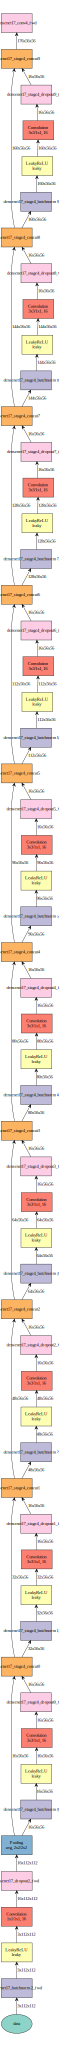

In [38]:
mx.viz.plot_network( net(mx.sym.var('data')), shape={'data':(1,3,112,112)})

In [ ]:
128x56x56

In [195]:

class AttentionBlock(nn.HybridBlock):

    def __init__(self, num_feature_map, **kwargs):

        super(AttentionBlock, self).__init__(**kwargs)
        with self.name_scope():
            self.mean_block =  gluon.nn.HybridSequential()   
            self.mean_block.add(nn.AvgPool2D())
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.mean_block.add(nn.LeakyReLU(0.3))
            self.mean_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))

            self.max_block =  gluon.nn.HybridSequential()
            self.max_block.add(nn.MaxPool2D())
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
            self.max_block.add(nn.LeakyReLU(0.3))
            self.max_block.add(nn.Conv2D(num_feature_map, kernel_size=1, use_bias=False))
    
    def hybrid_forward(self, F, x):
        mean_block_out = self.mean_block(x)
        max_block_out = self.max_block(x)
        
        return F.Activation(F.concat(mean_block_out, max_block_out,dim=2), 'sigmoid')

In [196]:
net = AttentionBlock(128)
net.cast('float16')
mx.viz.print_summary(
    net(mx.sym.var('data')), 
    shape={'data':(1,256,26,26)}, #set your shape here
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          256x26x26               0                                           
________________________________________________________________________________________________________________________
attentionblock11_pool0_fwd(Pooling)                 256x13x13               0           data                            
________________________________________________________________________________________________________________________
attentionblock11_conv0_fwd(Convolution)             128x13x13               32768       attentionblock11_pool0_fwd      
________________________________________________________________________________________________________________________
attentionblock11_leakyrelu0_fwd(